In [3]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.theodolite_utils as tu
import scripts.resection_functions as rf


In [4]:
# 17 02 2022 / 24 02 2022
Dist_prism_12_240222 = 0.8882613537922258
Dist_prism_13_240222 = 0.8262903370535766
Dist_prism_23_240222 = 1.0377436460567973
Dist_GPS_12_240222 = 0.7809786915630756
Dist_GPS_13_240222 = 0.8378323585433202
Dist_GPS_23_240222 = 0.5191788936274444   

# 07 03 2022
Dist_prism_12_070322 = 0.8832836583456264
Dist_prism_13_070322 = 0.8247449387008166
Dist_prism_23_070322 = 1.039409793600046
Dist_GPS_12_070322 = 0.7781099344563802
Dist_GPS_13_070322 = 0.8431026980109139
Dist_GPS_23_070322 = 0.5157221841320069

# 12 03 2022
Dist_prism_12_120322 = 0.8860734460339026
Dist_prism_13_120322 = 0.8303896290142598
Dist_prism_23_120322 = 1.0393117663247973
Dist_GPS_12_120322 = 0.7829424296161074
Dist_GPS_13_120322 = 0.8415176433032493
Dist_GPS_23_120322 = 0.5161917038941966

# 14 03 2022 / 16 03 2022
Dist_prism_12_140322 = 0.8873171656784946
Dist_prism_13_140322 = 0.8272212117473343
Dist_prism_23_140322 = 1.0379270641796363
Dist_GPS_12_140322 = 0.7829081036179948
Dist_GPS_13_140322 = 0.8424633975958637
Dist_GPS_23_140322 = 0.5165807364575292

# 31 03 2022
Dist_prism_12_310322 = 0.8873171656784946
Dist_prism_13_310322 = 0.8272212117473343
Dist_prism_23_310322 = 1.0379270641796363
Dist_GPS_12_310322 = 0.7829081036179948
Dist_GPS_13_310322 = 0.8424633975958637
Dist_GPS_23_310322 = 0.5165807364575292

# 27 04 2022
Dist_prism_12_270422 = 0.8856608085851714
Dist_prism_13_270422 = 0.8264452483880412
Dist_prism_23_270422 = 1.0384219210289538
Dist_GPS_12_270422 = 0.7809547832390561
Dist_GPS_13_270422 = 0.8259590286006459
Dist_GPS_23_270422 = 0.5191274645630007  

# 27 04 2022 soir
Dist_prism_12_270422_soir = 0.8868846942534616
Dist_prism_13_270422_soir = 0.829169129877633
Dist_prism_23_270422_soir = 1.0387571594276301
Dist_GPS_12_270422_soir = 0.7837749633840095
Dist_GPS_13_270422_soir = 0.8323125081688734
Dist_GPS_23_270422_soir = 0.5187055120945835

# 05 05 2022
Dist_prism_12_050522 = 0.3819811991689936
Dist_prism_13_050522 = 0.4426382054042266
Dist_prism_23_050522 = 0.2564685508415531

# 13 05 2022
Dist_prism_12_130522 = 0.8113569618671205
Dist_prism_13_130522 = 0.8695313906832193
Dist_prism_23_130522 = 1.0383292631343506
Dist_GPS_12_130522 = 0.7800801192552722
Dist_GPS_13_130522 = 0.8396027021467387
Dist_GPS_23_130522 = 0.5157656903777014

# 23 05 2022
Dist_prism_12_230522 = 0.3851913749758221
Dist_prism_13_230522 = 0.4433899497583272
Dist_prism_23_230522 = 0.25861327466684897

# 25 05 2022
Dist_prism_12_250522 = 0.9095421527752512
Dist_prism_13_250522 = 0.7356677023921305
Dist_prism_23_250522 = 1.0283049452358466

# 22 06 2022
Dist_prism_12_220622 = 0.7359204697527427
Dist_prism_13_220622 = 0.9055056357941131
Dist_prism_23_220622 = 1.0268390664025775

# 30 06 2022
Dist_prism_12_300622 = 0.7297583705742492
Dist_prism_13_300622 = 0.9060320633355149
Dist_prism_23_300622 = 1.0319114860615324

# 11 07 2022
Dist_prism_12_110722 = 0.7290056530579362
Dist_prism_13_110722 = 0.906995998154099
Dist_prism_23_110722 = 1.029264651249632

# 17 07 2022
Dist_prism_12_170722 = 0.39002864329744197 
Dist_prism_13_170722 = 0.4452628757931205 
Dist_prism_23_170722 = 0.2597453130254009

In [6]:
# This cell gathers result for the inter-prism distance resection for the graphic below
# With a linear interpolation, and 3 CP only

rf = importlib.reload(rf)

name_param_file = 'f-2-1-1-1-6-1-L_'

linear_inter_prism_file_name = [
                                './data/prediction/TS/20220224/filtered/'+name_param_file,    # bad
                                './data/prediction/TS/20220307/filtered/'+name_param_file,    # okay
                                './data/prediction/TS/20220314/filtered/'+name_param_file,    # okay
                                './data/prediction/TS/20220316/filtered/'+name_param_file,    # not great
                                './data/prediction/TS/20220331-1/filtered/'+name_param_file,  # okay
                                './data/prediction/TS/20220513/01/filtered/'+name_param_file,   # not bad!
                                './data/prediction/TS/20220513/02/filtered/'+name_param_file,   # badder
                                './data/prediction/TS/20220513/03/filtered/'+name_param_file,   # not great
                                './data/prediction/TS/20220513/04/filtered/'+name_param_file,   # best one yet
                                './data/prediction/TS/20220513/06/filtered/'+name_param_file,   # okay
                                './data/prediction/TS/20220525/01/filtered/'+name_param_file,
                                './data/prediction/TS/20220525/02/filtered/'+name_param_file,
                                './data/prediction/TS/20220622-1/filtered/'+name_param_file,
                                './data/prediction/TS/20220622-2/filtered/'+name_param_file,
                                './data/prediction/TS/20220630-1/filtered/'+name_param_file,
                                './data/prediction/TS/20220630-2/filtered/'+name_param_file,    # okay
                                './data/prediction/TS/20220711/02/filtered/'+name_param_file   # bad
    
#                                 './data/prediction/TS/20220331-2/filtered/'+name_param_file,  # bad
#                                 './data/prediction/TS/20220505_cones/filtered/f-2-1-1-1-6-1-L_',  # badder
#                                 './data/prediction/TS/20220505_empty/filtered/f-2-1-1-1-6-1-L_',  # badder
#                                 './data/prediction/TS/20220523_cones/filtered/f-2-1-1-1-6-1-L_',
#                                 './data/prediction/TS/20220523_constrained/filtered/f-2-1-1-1-6-1-L_',
#                                 './data/prediction/TS/20220523_empty/filtered/f-2-1-1-1-6-1-L_',
#                                 './data/prediction/TS/20220523_other_tunnel/filtered/f-2-1-1-1-6-1-L_',
#                                 './data/prediction/TS/20220717/02/filtered/f-2-1-1-1-6-1-L_',
#                                 './data/prediction/TS/20220717/03/filtered/f-2-1-1-1-6-1-L_',
#                                 './data/prediction/TS/20220717/04/filtered/f-2-1-1-1-6-1-L_'
                               ]
file_name_marker = [
                    './data/total_station/20220224/20220224_theodolite_reference_prisms.txt',
                    './data/total_station/20220307/theodolite_reference_prisms.txt',
                    './data/total_station/20220314/theodolite_reference_prisms.txt',
                    './data/total_station/20220316/theodolite_reference_prisms.txt',
                    './data/total_station/20220331-1/theodolite_reference_prisms.txt',
                    './data/total_station/20220513_morning_lidar/theodolite_reference_prisms.txt',
                    './data/total_station/20220513_morning_without_lidar_1/theodolite_reference_prisms.txt',
                    './data/total_station/20220513_morning_without_lidar_2/theodolite_reference_prisms.txt',
                    './data/total_station/20220513_evening_lidar/theodolite_reference_prisms.txt',
                    './data/total_station/20220513_evening_without_lidar_2/theodolite_reference_prisms.txt',
                    './data/total_station/20220525/theodolite_reference_prisms.txt',
                    './data/total_station/20220525/theodolite_reference_prisms.txt',
                    './data/total_station/20220622-1/theodolite_reference_prisms_2.txt',
                    './data/total_station/20220622-2/theodolite_reference_prisms_2.txt',
                    './data/total_station/20220630-1/theodolite_reference_prisms_without_first_two.txt',
                    './data/total_station/20220630-2/theodolite_reference_prisms_without_first_two.txt',
                    './data/total_station/20220711/theodolite_reference_prisms_1_to_10.txt'
    
#                     './data/total_station/20220331-2/theodolite_reference_prisms.txt',
#                     './data/total_station/20220505_cones/theodolite_reference_prisms.txt',
#                     './data/total_station/20220505_empty/theodolite_reference_prisms.txt',
#                     './data/total_station/20220523_cones/theodolite_reference_prisms.txt',
#                     './data/total_station/20220523_constrained/theodolite_reference_prisms.txt',
#                     './data/total_station/20220523_empty/theodolite_reference_prisms.txt',
#                     './data/total_station/20220523_other_tunnel/theodolite_reference_prisms.txt',
#                     './data/total_station/20220717/theodolite_reference_prisms.txt',
#                     './data/total_station/20220717/theodolite_reference_prisms.txt',
#                     './data/total_station/20220717/theodolite_reference_prisms.txt'
                   ]

Inter_distance = [
                  [Dist_prism_12_240222,Dist_prism_13_240222,Dist_prism_23_240222,Dist_GPS_12_240222,Dist_GPS_13_240222,Dist_GPS_23_240222],
                  [Dist_prism_12_070322,Dist_prism_13_070322,Dist_prism_23_070322,Dist_GPS_12_070322,Dist_GPS_13_070322,Dist_GPS_23_070322],
                  [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
                  [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
                  [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],
                  [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
                  [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
                  [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
                  [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
                  [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],               
                  [Dist_prism_12_250522,Dist_prism_13_250522,Dist_prism_23_250522],
                  [Dist_prism_12_250522,Dist_prism_13_250522,Dist_prism_23_250522],
                  [Dist_prism_12_220622,Dist_prism_13_220622,Dist_prism_23_220622],
                  [Dist_prism_12_220622,Dist_prism_13_220622,Dist_prism_23_220622],
                  [Dist_prism_12_300622,Dist_prism_13_300622,Dist_prism_23_300622],
                  [Dist_prism_12_300622,Dist_prism_13_300622,Dist_prism_23_300622],
                  [Dist_prism_12_110722,Dist_prism_13_110722,Dist_prism_23_110722]
    
#                   [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],
#                   [Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522],
#                   [Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522],
#                   [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
#                   [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
#                   [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
#                   [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
#                   [Dist_prism_12_170722,Dist_prism_13_170722,Dist_prism_23_170722],
#                   [Dist_prism_12_170722,Dist_prism_13_170722,Dist_prism_23_170722],
#                   [Dist_prism_12_170722,Dist_prism_13_170722,Dist_prism_23_170722]
                 ]

velocity_outlier_list = [1,1,1.5,1,2,
                         1.5,2,1,1,1.5,
                         1,1,1,1.5,2,
                         1,2
                         
# #                          2,2,2,2,2,
# #                          2,2,2,2                   
]


# errors_linear_inter_prism_3cp = []
# errors_linear_inter_prism_exp_3cp = []
# errors_linear_cp_exp_3cp = []
# TF_list_linear_inter_prism_3cp = []
# for i,j,k,l,m in zip(linear_inter_prism_file_name,file_name_marker,Inter_distance,velocity_outlier_list, saving_file_path):
    
#     print("dont give up! It: ", i)
    
#     dist_error,_,errors_prism,_, errors_exp, TF_list = rf.one_inter_prism_resection(Inter_distance=k, 
#                             file_name=i, file_name_marker=j, rate=10, prior = "CP", velocity_outlier = l, 
#                             threshold_training = 0.75, number_iteration = 1, threshold_marker=3, min_6dof=True)
#     print(np.median(errors_prism),np.std(errors_prism))
#     errors_linear_inter_prism_exp_3cp += dist_error
#     errors_linear_cp_exp_3cp += errors_prism
#     TF_list_linear_inter_prism_3cp += TF_list
#     errors_linear_inter_prism_3cp += errors_prism


In [74]:
rf = importlib.reload(rf)

index_file = 12
i = linear_inter_prism_file_name[index_file]
j = file_name_marker[index_file]
k = Inter_distance[index_file]
l = [0.01, 0.1, 0.5, 1, 2]
m = ''

RF = ['','']
for speed in l:
    print(i)
    dist_error,_,errors_prism,_, errors_exp, TF_list = rf.one_inter_prism_resection_advanced(Inter_distance=k, 
                            file_name=i, file_name_marker=j, RF=RF, rate=10, prior = "PTP", velocity_outlier = speed, 
                            threshold_training = 0.75, number_iteration = 1, threshold_marker=1, min_6dof=True)
    RF1 = TF_list[0][1]
    RF2 = TF_list[0][2]
    r1 = R.from_matrix(RF1[0:3,0:3])
    euler1 = r1.as_euler('xyz', degrees=True)
    r2 = R.from_matrix(RF2[0:3,0:3])
    euler2 = r2.as_euler('xyz', degrees=True)
    print(RF1[0:3,3],RF2[0:3,3])
    print(euler1,euler2)
    r1 = R.from_euler('xyz', [0,0,euler1[2]], degrees=True)
    r2 = R.from_euler('xyz', [0,0,euler2[2]], degrees=True)
    RF1[0:3,0:3] = r1.as_matrix()
    RF2[0:3,0:3] = r2.as_matrix()
    RF = [RF1,RF2]
    print("Cp error: ", np.median(errors_prism), np.std(errors_prism))
    print("Inter-prism error: ", np.median(errors_exp), np.std(errors_exp))

./data/prediction/TS/20220622-1/filtered/f-2-1-1-1-6-1-L_
Selected points:  907
The maximum number of function evaluations is exceeded.
Function evaluations 100000, initial cost 4.7531e-05, final cost 1.2400e-08, first-order optimality 9.82e-08.
Time [s]:  1170.0587193965912
Results done !
[ 1.12505809 -1.39762678  0.41053194] [1.36995112 0.54767295 0.81100954]
[  0.94901186  -1.53277122 -16.87979244] [-1.71480709e+00  6.34609387e-03  1.01181143e+02]
Cp error:  238.5708813472659 257.0136182558327
Inter-prism error:  12.98911859159546 48.400091992936275
./data/prediction/TS/20220622-1/filtered/f-2-1-1-1-6-1-L_
Selected points:  970
The maximum number of function evaluations is exceeded.
Function evaluations 100007, initial cost 3.6206e-05, final cost 1.7235e-08, first-order optimality 2.86e-07.
Time [s]:  1195.707584142685
Results done !
[ 1.13696387 -1.38825676  0.44195119] [1.38413246 0.56570044 0.82603854]
[  0.97729595  -1.73273023 -16.80074368] [ -1.83821495   0.11808672 101.301989

In [40]:
print(RF)
T =TF_list[0][1]
r = R.from_matrix(T[0:3,0:3])
euler = r.as_euler('xyz', degrees=True)
print(euler)

[[array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[-0.99433175,  0.10515874, -0.0156847 ,  0.94627146],
       [-0.10510205, -0.99445171, -0.00439841,  0.11311803],
       [-0.01606021, -0.00272498,  0.99986731,  0.94495067],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), array([[-8.47937334e-01,  5.30081042e-01,  4.04548473e-03,
         1.99093606e+00],
       [-5.30084462e-01, -8.47944806e-01,  2.62214450e-04,
         7.34976358e-01],
       [ 3.56934268e-03, -1.92210718e-03,  9.99991783e-01,
         6.83668108e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]]
[-1.56150221e-01  9.20221553e-01 -1.73966173e+02]


In [50]:
%matplotlib notebook
tu = importlib.reload(tu)

index_file = 1
path = linear_inter_prism_file_name[index_file]

trimble_1 = tu.read_prediction_data_resection_csv_file(path+"1.csv")
trimble_2 = tu.read_prediction_data_resection_csv_file(path+"2.csv")
trimble_3 = tu.read_prediction_data_resection_csv_file(path+"3.csv")

In [51]:
print(len(np.array(trimble_1)))
print(len(np.array(trimble_2)))
print(len(np.array(trimble_3)))

16166
16166
16166


In [52]:
tu = importlib.reload(tu)
rate = 10
velocity_outlier_list = 1
index1 = tu.find_not_moving_points_GP(np.array(trimble_1), velocity_outlier_list, 1/rate) 
index2 = tu.find_not_moving_points_GP(np.array(trimble_2), velocity_outlier_list, 1/rate) 
index3 = tu.find_not_moving_points_GP(np.array(trimble_3), velocity_outlier_list, 1/rate)  

In [16]:
#p1s_l = np.array(trimble_1)[:,1:5]
#p2s_l = np.array(trimble_2)[:,1:5]
#p3s_l = np.array(trimble_3)[:,1:5]
p1s_l = np.array(trimble_1)[:,1:5]
p2s_l = np.array(trimble_2)[:,1:5]
p3s_l = np.array(trimble_3)[:,1:5]
print(len(np.array(trimble_1).T[0]),len(np.array(trimble_2).T[0]),len(np.array(trimble_3).T[0]))
print(len(p1s_l),len(p2s_l),len(p3s_l))

4366 4366 4366
4366 4366 4366


<IPython.core.display.Javascript object>


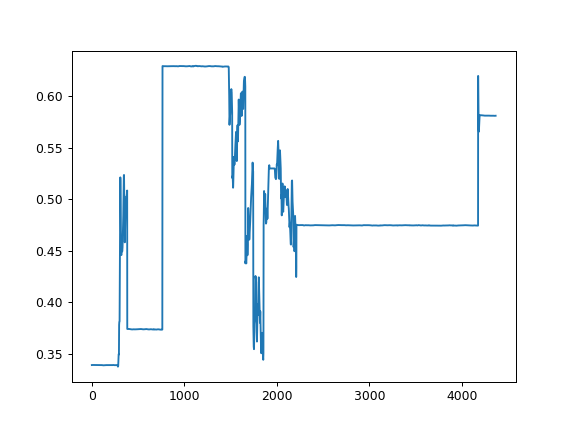

In [17]:
%matplotlib notebook

#plt.figure(figsize=(10,3))
#plt.scatter(p1s_l[:,0],p1s_l[:,2])
#plt.scatter(p2s_l[:,0],p2s_l[:,2])
#plt.scatter(p3s_l[:,0],p3s_l[:,2])
plt.plot(p2s_l[:,2])

plt.show()

In [18]:
import time

Distan_prism = Inter_distance[index_file]

f = lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:], Dist_prism_12, Dist_prism_13, Dist_prism_23)

# start_time = time.time()
# res = scipy.optimize.minimize(lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:], Dist_prism_12, Dist_prism_13, 
#                             Dist_prism_23), x0=np.zeros((12,1)), tol=1e-8)

# stop_time = time.time()
# print(stop_time - start_time)
# print(res.fun)
# xi_12 = res.x[:6]
# xi_13 = res.x[6:] 
# T12 = exp_T(xi_12)
# T13 = exp_T(xi_13)

In [145]:
print(len(p1s_l))
print(res.fun/len(p1s_l))

2004
7.779765161881842e-05


In [146]:
p1s_r = p1s_l
p2s_r = T12@p2s_l.T
p3s_r = T13@p3s_l.T

#p1s_r = np.array(trimble_1)[:,1:5]
#p2s_r = T12@np.array(trimble_2)[:,1:5].T
#p3s_r = T13@np.array(trimble_3)[:,1:5].T

print(T12)
print(T13)

[[ 0.7991318   0.60115147  0.0022945   1.35792274]
 [-0.60113557  0.79906766  0.01126538  0.52818966]
 [ 0.00493874 -0.01038183  0.99993391  0.24963809]
 [ 0.          0.          0.          1.        ]]
[[ 0.29507198  0.95545939  0.00546714  1.58307843]
 [-0.95479457  0.29464111  0.03942013  1.34041032]
 [ 0.03605349 -0.01685177  0.99920777  0.10151842]
 [ 0.          0.          0.          1.        ]]


<IPython.core.display.Javascript object>


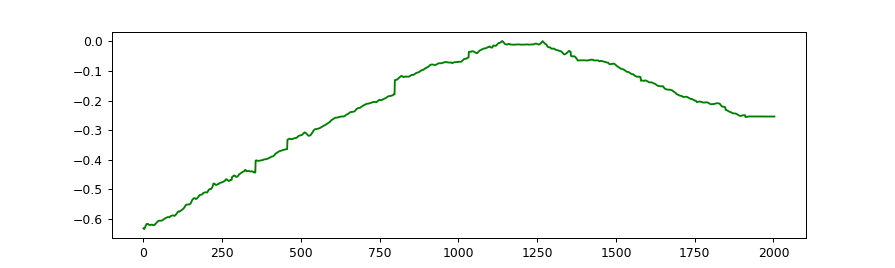

In [147]:
%matplotlib notebook

p2s_rarr = np.array(p2s_r).T
p3s_rarr = np.array(p3s_r).T

plt.figure(figsize=(10,3))
#plt.scatter(p1s_r[:,0],p1s_r[:,1], color='b')
#plt.scatter(p2s_rarr[:,0],p2s_rarr[:,2], color='r')
#plt.scatter(p3s_rarr[:,1],p3s_rarr[:,2], color='g')
plt.plot(p2s_rarr[:,2], color='g')
plt.show()

<IPython.core.display.Javascript object>


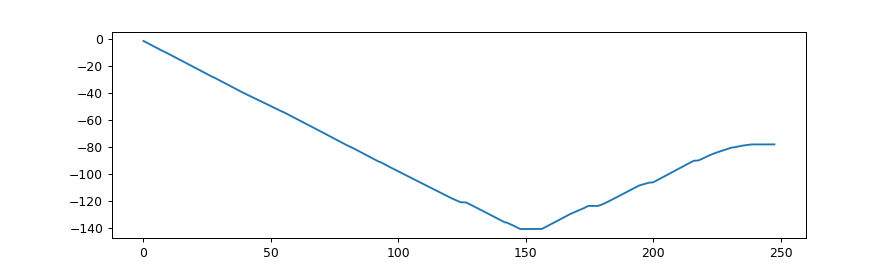

In [149]:
plt.figure(figsize=(10,3))
offset_timestamp = min(np.array(trimble_1)[0,0],np.array(trimble_2)[0,0],np.array(trimble_3)[0,0])
#plt.plot(np.array(trimble_1)[:,0]-offset_timestamp,p1s_r[:,0])
plt.plot(np.array(trimble_2)[:,0]-offset_timestamp,p2s_rarr[:,0])
#plt.plot(np.array(trimble_3)[:,0]-offset_timestamp,p3s_rarr[:,0])
plt.show()

<IPython.core.display.Javascript object>


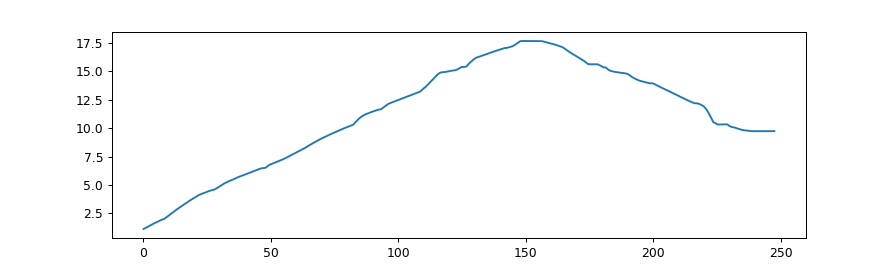

In [150]:
plt.figure(figsize=(10,3))
#plt.plot(np.array(trimble_1)[:,0]-offset_timestamp,p1s_r[:,1])
plt.plot(np.array(trimble_2)[:,0]-offset_timestamp,p2s_rarr[:,1])
#plt.plot(np.array(trimble_3)[:,0]-offset_timestamp,p3s_rarr[:,1])
plt.show()

<IPython.core.display.Javascript object>


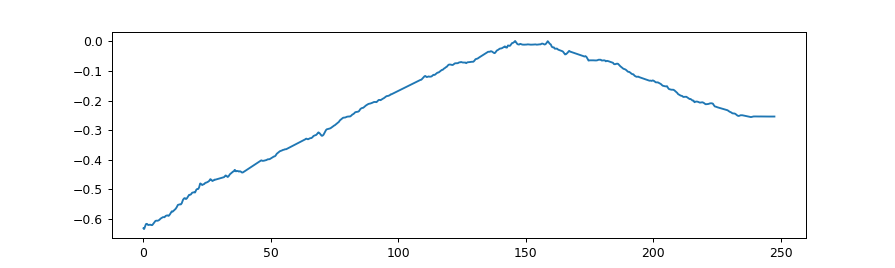

In [151]:
plt.figure(figsize=(10,3))
#plt.plot(np.array(trimble_1)[:,0]-offset_timestamp,p1s_r[:,2])
plt.plot(np.array(trimble_2)[:,0]-offset_timestamp,p2s_rarr[:,2])
#plt.plot(np.array(trimble_3)[:,0]-offset_timestamp,p3s_rarr[:,2])
plt.show()

In [152]:
dist_prism = []
timestamp = np.array(trimble_1)[:,0]
for i in range(0,len(timestamp)-1):
    dp1 = abs(np.linalg.norm(p1s_r[i,0:3]-p2s_rarr[i,0:3])-Dist_prism_12)*1000
    dp2 = abs(np.linalg.norm(p1s_r[i,0:3]-p3s_rarr[i,0:3])-Dist_prism_13)*1000
    dp3 = abs(np.linalg.norm(p3s_rarr[i,0:3]-p2s_rarr[i,0:3])-Dist_prism_23)*1000
    dist_prism.append(np.array([timestamp[i], dp1, dp2, dp3]))
dist_prism = np.array(dist_prism)

Mean inter-prism [mm]:  3.52 3.92 2.07
Std inter-prism [mm]:  4.29 4.77 2.152


<IPython.core.display.Javascript object>


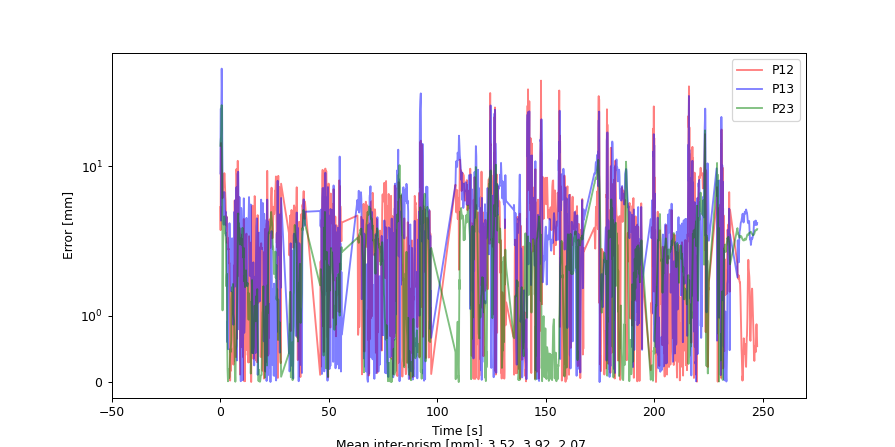

In [153]:
print("Mean inter-prism [mm]: ", round(np.mean(dist_prism[:,1]),2), round(np.mean(dist_prism[:,2]),2), round(np.mean(dist_prism[:,3]),2))
print("Std inter-prism [mm]: ", round(np.std(dist_prism[:,1]),2), round(np.std(dist_prism[:,2]),2), round(np.std(dist_prism[:,3]),3))
plt.figure(figsize=(10,5))
offset_timestamp = min(dist_prism[:,0])
plt.subplot(111)
plt.plot(dist_prism[:,0]-offset_timestamp, dist_prism[:,1], label="P12", color="red", alpha=0.5)
plt.plot(dist_prism[:,0]-offset_timestamp, dist_prism[:,2], label="P13", color="blue", alpha=0.5)
plt.plot(dist_prism[:,0]-offset_timestamp, dist_prism[:,3], label="P23", color="green", alpha=0.5)
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_ylabel("Error [mm]")
limitx = [-50, 270]
ax.set_xlim(limitx)
ax.set_xlabel("Time [s] \n Mean inter-prism [mm]: " + str(round(np.mean(dist_prism[:,1]),2)) + "  " + str(round(np.mean(dist_prism[:,2]),2)) + "  " + str(round(np.mean(dist_prism[:,3]),2))
             + "\n Std inter-prism [mm]: " + str(round(np.std(dist_prism[:,1]),2)) + "  " + str(round(np.std(dist_prism[:,2]),2)) + "  " + str(round(np.std(dist_prism[:,3]),2)))
plt.savefig("./figs/20220505_cones_dynamic_L-1-6.jpg")
#plt.savefig("./figs/20220505_cones_dynamic.jpg")
#plt.savefig("./figs/20220523_empty.jpg")
plt.show()  

In [126]:
# Convert point data to csv file
ttfu = importlib.reload(ttfu)

# Trajectory total station (time, point data) x3
ttfu.Convert_datap_to_csv(np.array(trimble_1)[:,0], np.array(p1s_r), "./data/prediction/nr_trimble_1.csv")
ttfu.Convert_datap_to_csv(np.array(trimble_2)[:,0], np.array(p2s_rarr), "./data/prediction/nr_trimble_2.csv")
ttfu.Convert_datap_to_csv(np.array(trimble_3)[:,0], np.array(p3s_rarr), "./data/prediction/nr_trimble_3.csv")

Conversion done !
Conversion done !
Conversion done !


In [47]:
ttfu = importlib.reload(ttfu)
save_tf = True
name_file = './data/calibration/tf_automated_resection/20220505_empty_tf_a.csv'
if(save_tf):
    ttfu.save_tf(np.identity(4), T12, T13, name_file)

Conversion done !
